In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import control as ctrl
import matplotlib.pyplot as plt
import vibrationtesting as vt
import numpy as np
import scipy as sp
import scipy.linalg as la
import scipy.signal as sig
import scipy.io as io
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

# Problem 1

In [2]:
M = sp.array([[3,0],[0,5]])
M

array([[3, 0],
       [0, 5]])

In [3]:
K = sp.array([[2,-1],[-1,2]])
K

array([[ 2, -1],
       [-1,  2]])

In [4]:
C = K * .1
C

array([[ 0.2, -0.1],
       [-0.1,  0.2]])

In [5]:
#Note that the eigenvalus show up out of desired order... with numerically induces imaginary errors. 
w, vr = la.eig(la.solve(M,K))
print(w)
print(vr)
# Let's eliminate the imaginary part. 
w = abs(w)
print(w)

[ 0.82392660+0.j  0.24274007+0.j]
[[ 0.90440309  0.61810602]
 [-0.4266791   0.78609474]]
[ 0.8239266   0.24274007]


In [6]:
vr.T@K@vr # Check: the eigenvectors diagonalize K

array([[  2.77177979e+00,  -2.22044605e-16],
       [  0.00000000e+00,   1.02822021e+00]])

In [7]:
Mnn = vr.T@M@vr # Check: the eigenvectors diagonalize M, but they are not mass normalized
Mnn

array([[  3.36411011e+00,  -2.22044605e-16],
       [  0.00000000e+00,   4.23588989e+00]])

In [8]:
# We could round this to make it look nice
Mnn = sp.around(Mnn, 16)
Mnn

array([[  3.36411011e+00,  -2.00000000e-16],
       [  0.00000000e+00,   4.23588989e+00]])

In [9]:
# We could do this a column at a time, but instead I created a 
# diagnoal matrix of the square roots of the diagonals inverted
normalizematrix = sp.sqrt(sp.array([[1./Mnn[0,0],0],[0,1./Mnn[1,1]]]))
Psi = vr@normalizematrix
Psi

array([[ 0.49309084,  0.30032442],
       [-0.23263029,  0.38194652]])

In [10]:
# Still a bit of numerical error
Psi.T@M@Psi

array([[  1.00000000e+00,  -5.14230956e-17],
       [ -4.20066019e-18,   1.00000000e+00]])

In [11]:
# The lambda matrix.
# Note that this was all unnecessary. We only needed mass-normalized mode 
# shapes and natural frequencies, but this does simplify finding zeta
Psi.T@K@Psi

array([[  8.23926596e-01,  -1.34517801e-17],
       [ -8.28786866e-18,   2.42740070e-01]])

In [12]:
omega1 = sp.sqrt((Psi.T@K@Psi)[1,1])
omega1

0.49268658438262936

In [13]:
omega2 = sp.sqrt((Psi.T@K@Psi)[0,0])
omega2

0.9077040245785214

In [14]:
# First mode shape
psi1 = Psi[:,1]
psi1

array([ 0.30032442,  0.38194652])

In [15]:
# Second mode shape
psi2 = Psi[:,0]
psi2

array([ 0.49309084, -0.23263029])

In [16]:
# first damping ratio (diagonalize the damping matrix, pull out the 1,1 element, divide by 2 omega1)
zeta1 = (Psi.T@C@Psi/2/omega1)[1,1]
zeta1

0.024634329219131466

In [17]:
# second damping ratio (diagonalize the damping matrix, pull out the 1,1 element, divide by 2 omega2)
zeta2 = (Psi.T@C@Psi/2/omega2)[0,0]
zeta2

0.045385201228926073

In [18]:
h11_1 = psi1[0]*psi1[0]/(omega1**2 - 1 + 2 * 1j * omega1 * 1) # first mode contribution
h11_2 = psi2[0]*psi2[0]/(omega2**2 - 1 + 2 * 1j * omega2 * 1) # second mode contribution
print('The percent magnitude error in the first degree of freedom is {:.0%}'.format(abs(h11_2)/abs(h11_1+h11_2)))


The percent magnitude error in the first degree of freedom is 67%


In [19]:
h12_1 = psi1[0]*psi1[1]/(omega1**2 - 1 + 2 * 1j * omega1 * 1) # first mode contribution
h12_2 = psi2[0]*psi2[1]/(omega2**2 - 1 + 2 * 1j * omega2 * 1) # second mode contribution
print('The percent magnitude error in the first degree of freedom is {:.0%}'.format(abs(h12_2)/abs(h12_1+h12_2)))


The percent magnitude error in the first degree of freedom is 123%


This shouldn't be surprising as the driving frequency of 1 rad/sec is very close to the second natural frequency of 0.90. Neglecting thie mode would be ludicrous (problem was designed as such). 

# Problem 2

In [20]:
Sxx = 1
Sff = 1.7
Sfx = 0.95459 - 0.94549j
Sxf = sp.conj(Sfx)

In [21]:
H1 = Sfx / Sff
H1

(0.5615235294117648-0.5561705882352942j)

In [22]:
H2 = Sxx/ Sxf
H2

(0.52880206390286111-0.52376105280750496j)

In [23]:
gammasq = Sfx * Sxf / Sff / Sxx
gammasq

(1.0618784754117647+0j)

In [24]:
# Alternatively
H1/H2

(1.0618784754117649+0j)

This can't be! It's impossible. The data is bad. 



In [25]:
lam, eig = la.eig(sp.array([[Sff, Sfx],[Sxf, Sxx] ]))
print(lam)
print(-eig[0,0]/eig[1,0])
print(-eig[0,1]/eig[1,1])

[ 2.73841399 -1.19637664e-16j -0.03841399 +2.30659966e-16j]
(-0.919276905939+0.910513541726j)
(0.549115461207-0.54388080476j)


Because we have a non-positive eigenvalue... we have negative noise (squared)? This would be imaginary noise? This is infeasible. Send the intern back, but supervise them more carefully.

# Problem 3

* Response sensor noise may have a substantial impact, but at resonance you will likely not notice it as the true signal will dominate. It shouldn't impact an $H_1$ estimate, but will slightly increase an $H_2$ estimate, but not by much. If you see results looking cleaner at resonance, your data is likely OK. You can have obviously bad data everywhere else but may still get away with it at resonance. It may cause modest drops in the coherence near resonance. 
* Your anti-resonances (and coherence) will likely look terrible as the noise will dominate the response data. I'mpact is greater with the $H_2$ estimate method.
* Damping estimates will likely be reasonable as the sharpness of the peak won't be effected since the resonant peak is marginally effected, regardless of the method chosen. However, $H_1$ is prudent if noise is completely in the output sensor. 

# Problem 4

Hopefully you did this in the lab. If not, you could use the vibration testing toolbox to run a simulation. What happens is the Hanning window makes the excitation look smaller than it is and amplifies the noise in the middle of the window. Further, the decaying explonential will now have what looks like an increase in amplitude over the first part of the window, with noise being the only cause. You will likely have a phase error at resonance (increase of 180 instead of decrease). 


# Problem 1

In [26]:
filedata = io.matlab.loadmat('testdata.mat')
filedata

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Thu Mar 31 09:40:53 2016',
 '__version__': '1.0',
 't': array([[  0.00000000e+00],
        [  1.00000000e-03],
        [  2.00000000e-03],
        ..., 
        [  1.02200000e+00],
        [  1.02300000e+00],
        [  1.02400000e+00]]),
 'xn': array([[-0.75346434],
        [-1.21481935],
        [ 0.89769072],
        ..., 
        [ 1.14704764],
        [ 1.24520198],
        [ 2.46514216]]),
 'yn': array([[-0.86270794],
        [ 0.42088839],
        [ 1.2815909 ],
        ..., 
        [-0.03841947],
        [ 1.04790065],
        [ 1.07585922]])}

In [27]:
# Needs some cleanup. 
t = filedata['t']
xn = filedata['xn']
yn = filedata['yn']
t = t[:,0]
xn = xn[:,0]
yn = yn[:,0]

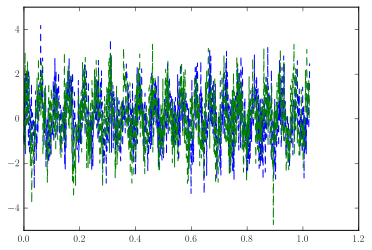

In [28]:
plt.plot(t,xn)
plt.plot(t,yn)

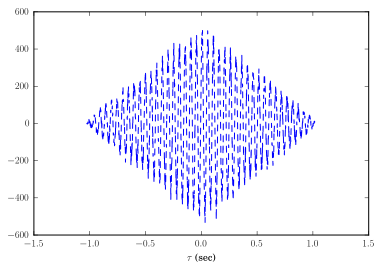

In [29]:
tau, xcor = vt.xcorr(t, xn, yn)
plt.plot(tau, xcor)
plt.xlabel('$\\tau$ (sec)')

[0, 0.03, 0, 525]

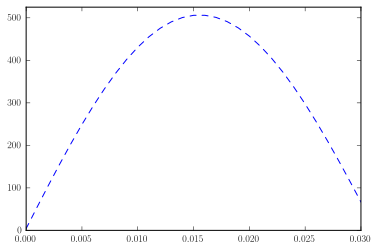

In [30]:
tau, xcor = vt.xcorr(t, sp.sin(100*t), sp.cos(100*t))
plt.plot(tau, xcor)
plt.axis([0,0.03,0,525])
# bump to the right means the second signal leads the first (just a gut-check)
# It should lead by pi/2 rad , which would mean pi/2/100 = 0.157 

[-0.05, 0.05, 300, 500]

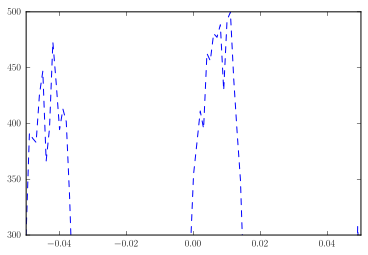

In [31]:
tau, xcor = vt.xcorr(t, xn, yn)
plt.plot(tau, xcor)
plt.axis([-.05, .05, 300, 500])
# This is disappointingly ugly

Well, this looks like pretty noisy data, however, we can see that $y$ leads $x$. It looks like a peak would be near 0.007 sec or so. Let's try that. 

[-0.15, 0.15, 300, 500]

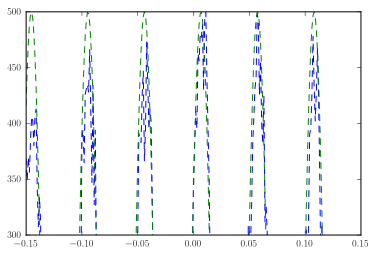

In [38]:
# Here I'm guessing parameters to make it fit. These seem reasonable
plt.plot(tau, xcor)
plt.plot(tau, sp.sin(124 * (tau+0.006))* 500)
plt.axis([-.15, .15, 300, 500])

#### So, this gives me a time lead of y leading x by 0.006 sec, with a phase lead of about 124*0.006 = 0.744 (true answer is 0.75 rad, 0.00605 sec)

Let's try something different.
A cross spectrum density. 

[0, 30, -80, 0]

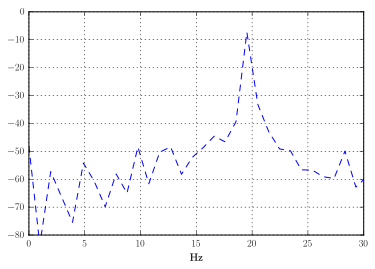

In [34]:
f, Pxy = vt.crsd(xn, yn, t, windowname = 'none')
plt.plot(f, 20*sp.log10(abs(Pxy[0,:,0])))
plt.grid()
plt.xlabel('Hz')
plt.axis([0,30,-80,0])
#plt.axis([115,130,-80,0])
#Nice clean frequency content. 

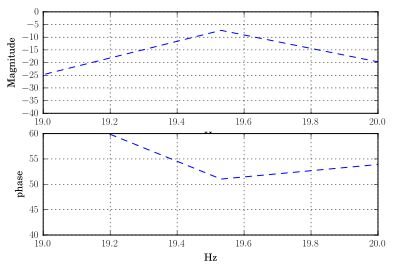

In [47]:
f, Pxy = vt.crsd(xn, yn, t, windowname = 'none')
plt.subplot(211)
plt.plot(f, 20*sp.log10(abs(Pxy[0,:,0])))
plt.xlabel('Hz')
plt.ylabel('Magnitude')
plt.axis([19.0,20,-40,0])
plt.grid()
# Zoom in- it's about 19.5 Hz. (actual 19.735) 
plt.subplot(212)
plt.plot(f, sp.angle(Pxy[0,:,0])*180/sp.pi)
x1,x2,y1,y2 = plt.axis()
plt.xlabel('Hz')
plt.ylabel('phase')
plt.axis([19.0,20,40,60])
plt.grid()
# Phase looks smooth in this region. It's about 51 deg, or 0.89 rad

In [49]:
# So I get a phase lead of about 0.89 rad, and a time lead of about 
tlead = 0.89/124
tlead

0.00717741935483871

Well, we have a time lead of $0.006 <  t_{lead} < 0.0071$ and a phase lead of $0.74 <\phi< 0.89$ rad. ($42 <\phi< 50$ deg)

# Problem 2

In [ ]:
M = sp.array([[2, 0],[0,7]])
K = sp.array([[2, -1],[-1,2]])
C = K*0.1

In [ ]:
A = sp.vstack((sp.hstack((sp.eye(2)*0,sp.eye(2))),sp.hstack((-la.solve(M,K),-la.solve(M,C)))))
B = sp.array([[0],[0],[1],[-1]])
C_state = sp.array([1,0,0,0])
D = 0

## a)

In [ ]:
sys = ctrl.ss(A, B, C_state, D)
print(sys)

## b)

In [ ]:
C_d = sp.array([[0,0]])
C_v = sp.array([[0,0]])
C_a = sp.array([[1,0]])
Btilde = sp.array([[1],[-1]])
C_state = sp.hstack((-C_a@la.solve(M,K),-C_a@la.solve(M,C)))
D = C_a@la.solve(M,Btilde)
print('C = {}'.format(C_state))
print('D = {}'.format(D))

In [ ]:
sys2 = ctrl.ss(A, B, C_state, D)
print(sys2)

# Problem 3

In [ ]:
def ssfrf(sys, omega_low, omega_high, in_index, out_index):
        A, B, C, D = ctrl.ssdata(sys)
        sa = A.shape[0]
        omega = sp.linspace(omega_low, omega_high,1000)
        H = omega* 1j
        i = 0
        for i in sp.arange(len(omega)):
            w = omega[i]
            H[i] = (C@la.solve(w*1j*sp.eye(sa)-A,B)+D)[out_index,in_index]
        return omega, H

In [ ]:
w, H = ssfrf(sys, 0, 1.5, 0, 0)
plt.subplot(2,1,1)
plt.plot(w,20*sp.log10(abs(H)))
plt.grid()
plt.xlabel('Frequency (rad)')
plt.ylabel('Amplitude (dB)')
plt.subplot(2,1,2)
plt.plot(w,sp.angle(H)*180/sp.pi)
plt.grid()
plt.xlabel('Frequency (rad)')
plt.ylabel('Phase (deg)')


In [ ]:
w, H = ssfrf(sys2, 0, 1.5, 0, 0)
plt.subplot(2,1,1)
plt.plot(w,20*sp.log10(abs(H)))
plt.grid()
plt.xlabel('Frequency (rad)')
plt.ylabel('Amplitude (dB)')
plt.subplot(2,1,2)
plt.plot(w,sp.unwrap(sp.angle(H))*180/sp.pi)
plt.grid()
plt.xlabel('Frequency (rad)')
plt.ylabel('Phase (deg)')

# Problem 4

In [ ]:
t = sp.linspace(0,10,10000)
u = 5 * sp.sin(10*t)
yout, T, xout = ctrl.lsim(sys2, u, t)
plt.plot(t,yout)
plt.title('Transients apparent')
plt.grid()
plt.xlabel('Time (sec)')

In [ ]:
t = sp.linspace(0,1000,1000000)
u = 5 * sp.sin(10*t)
yout, T, xout = ctrl.lsim(sys2, u, t)
plt.plot(t[-1000:],yout[-1000:])
plt.grid()
plt.xlabel('Time (sec)')

In [ ]:
max(yout[-1000:]) # amplitude

In [ ]:
w, H = ssfrf(sys2, 10, 10, 0, 0) # Recall I wrote this in problem 3
# The results compare pretty well. 

In [ ]:
abs(H[0]) * 5

In [ ]:
sp.angle(H[0])

The solution from the FRF is thus $2.576 \sin 10 t + 0.02979$.

In [ ]:
plt.plot(t[-2000::10],yout[-2000::10],'.')
plt.plot(t[-2000:], abs(H[0]) * 5 * sp.sin(10*t[-2000:] + sp.angle(H[0])),'-')
plt.grid()